<a href="https://colab.research.google.com/github/seanita/deep_learning_with_python/blob/master/pretrained_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
imdb_dir = "/Users/seanitatolliver/Downloads/imdb"
train_dir = os.path.join(imdb_dir, 'train')

print(train_dir)

/Users/seanitatolliver/Downloads/imdb/train


In [0]:
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # Cut reviews off after 100 words
training_samples = 200
validation_samples = 10000 # Validate on 10k samples
max_words = 10000 # Get top 10k words in dataset

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [0]:
print(len(x_val))
print(len(y_val))

10000
10000


In [0]:
glove_dir = '/Users/seanitatolliver/Downloads/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    # print(word)
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, 
                    epochs=10, batch_size=32,
                    validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 1.0491 - acc: 0.5200 - val_loss: 0.6994 - val_acc: 0.4920
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.7170 - acc: 0.5800 - val_loss: 0.7711 - val_acc: 0.4928
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.6898 - acc: 0.7200 - val_loss: 0.8373 - val_acc: 0.4931
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4626 - acc: 0.7950 - val_loss: 0.7078 - val_acc: 0.5435
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2708 - acc: 0.9000 - val_loss: 0.7250 - val_acc: 0.5467
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1468 - acc: 0.9900 - val_loss: 1.4801 - val_acc: 0.4930
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1658 - acc: 0.9450 - val_loss: 0.8482 - val_acc: 0.5284
Epoch 8/10
200/200 [========

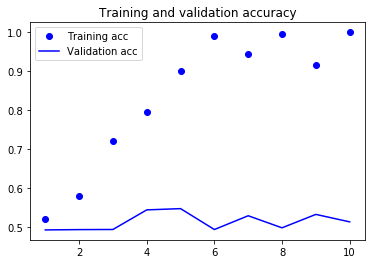

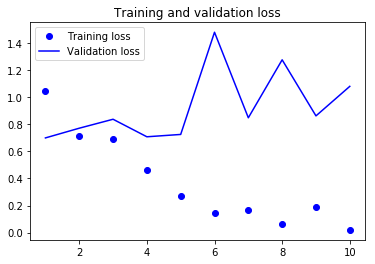

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()